# Transfer Learning

## Required Libraries

In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix

import seaborn as sns

import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Data preprocessing

### Python code to change names of screenshots named as robot(1).png,robot(2).png,robot(3).png,..... to robot1.png,robot2.png,robot3.png,.....

In [18]:
"""
import os
os.getcwd()
collection = 'C:\\Users\\Pahul\\Pictures\\Screenshots\\robot1\\'
for i, filename in enumerate(os.listdir(collection)):
    os.rename('C:\\Users\\Pahul\\Pictures\\Screenshots\\robot1\\' + filename, "robot" + str(i+1) + ".png")

"""

'\nimport os\nos.getcwd()\ncollection = \'C:\\Users\\Pahul\\Pictures\\Screenshots\\robot1\\\'\nfor i, filename in enumerate(os.listdir(collection)):\n    os.rename(\'C:\\Users\\Pahul\\Pictures\\Screenshots\\robot1\\\' + filename, "robot" + str(i+1) + ".png")\n\n'

### Python code to mirror all images in a folder

In [19]:
"""
import os
import cv2
os.getcwd()
directory = 'C:\\Users\\Pahul\\Pictures\\Screenshots\\main\\robot\\'
i=1
for file in os.listdir(directory):
     img = cv2.imread(directory + file)
     mirror_img = cv2.flip( img, 1 )
     cv2.imwrite("robot_aug"+str(i)+".png",mirror_img)
     i=i+1
"""

'\nimport os\nimport cv2\nos.getcwd()\ndirectory = \'C:\\Users\\Pahul\\Pictures\\Screenshots\\main\\robot\\\'\ni=1\nfor file in os.listdir(directory):\n     img = cv2.imread(directory + file)\n     mirror_img = cv2.flip( img, 1 )\n     cv2.imwrite("robot_aug"+str(i)+".png",mirror_img)\n     i=i+1\n'

### "RandomResizedCrop" transformation was important as in intital experiments the screenshots size was large and it caused the final image after transformation sometimes without the robot or people's images without any major feature. As a result the default scale and ratio was not used and it was changed to scale=(0.95, 1.0), ratio=(1.0, 1.1)and this gave us images with all the content
### ColorJitter was explored but the original image without jitter transform gave nice results

In [20]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(512,scale=(0.95, 1.0), ratio=(1.0, 1.1)),
        #transforms.ColorJitter(brightness=2, contrast=2, saturation=3, hue=0.3),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#data_dir = 'data/hymenoptera_data'
data_dir = 'data\OOC_image_dataset'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])

N_train = len(train_dataset)
N_valid = len(valid_dataset)
print(f"Training set size: {N_train} images")
print(f"Valdiation set size: {N_valid} images")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=24, shuffle=True, num_workers=4)

Training set size: 2130 images
Valdiation set size: 286 images


In [4]:
class_names = train_dataset.classes
print(class_names)

['bad', 'good']


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## The images of robots are all screenshots from the videos provided
## However, for people images, different scenarios were involved i.e. football players, simple images of people in natural backgrounds and images of faces in some cases

#### Here, this was run on my machine which had 6gb graphic card and hence batch size were kept at 12 but the images shown below were on batchsize 32

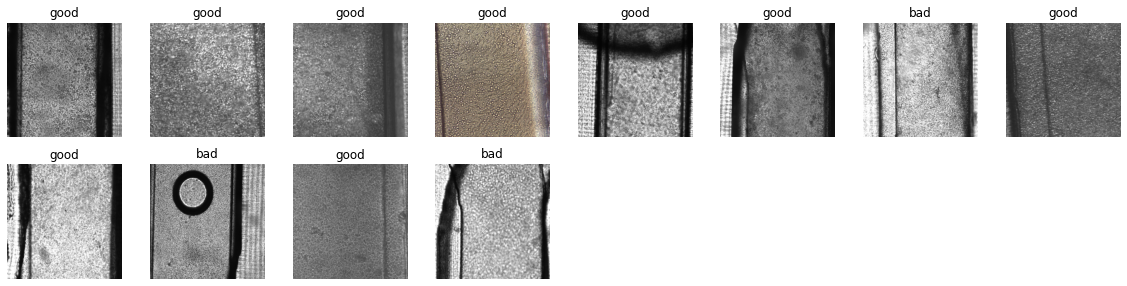

In [6]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)

    plt.figure(figsize=(8*2, 4*2))
    for i in range(12):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

# Get a batch of training data and displaying it
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

show_grid(inputs, titles=titles)

## The code provided previously in session4 is used for training, evaluating, saving

In [6]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """

    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []

    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)

    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""

    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []

    for epoch in range(num_epochs):

        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)

        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters

        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")

    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

In [7]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """

    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model, optimizer, epoch, stats


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

In [8]:
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [9]:
set_random_seed()

# Fine-tune VGG, ResNet and DenseNet for out custom dataset of humanoid robot classification (Binary classification Robot v.s. Human) and comparison.

### ResNet

In [12]:
# downloading pretrained model
#model = models.resnet18(pretrained=True)  # https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

# replacing classification head
#num_nuerons = model.fc.in_features
#model.fc = nn.Linear(num_nuerons, 2)


model = models.resnet18(pretrained=True)
num_nuerons = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_nuerons, 512),
    nn.ReLU(),
    nn.Linear(512, 2)
)

model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
start = time.time()
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=25
    )
end = time.time()

Epoch 1/25
    Train loss: 0.50295
    Valid loss: 0.69481
    Accuracy: 49.3006993006993%


Epoch 6/25
    Train loss: 0.08866
    Valid loss: 0.45276
    Accuracy: 82.16783216783216%


Epoch 11/25
    Train loss: 0.00864
    Valid loss: 0.34032
    Accuracy: 87.06293706293707%


Epoch 16/25
    Train loss: 0.0059
    Valid loss: 0.33272
    Accuracy: 87.41258741258741%


Epoch 21/25
    Train loss: 0.00467
    Valid loss: 0.31133
    Accuracy: 87.76223776223776%


Epoch 25/25
    Train loss: 0.00549
    Valid loss: 0.32362
    Accuracy: 87.41258741258741%


Training completed


In [15]:
print("Time Elapsed = ",end-start," seconds")

Time Elapsed =  5574.802086591721  seconds


In [16]:
print(count_model_params(model))

11440194


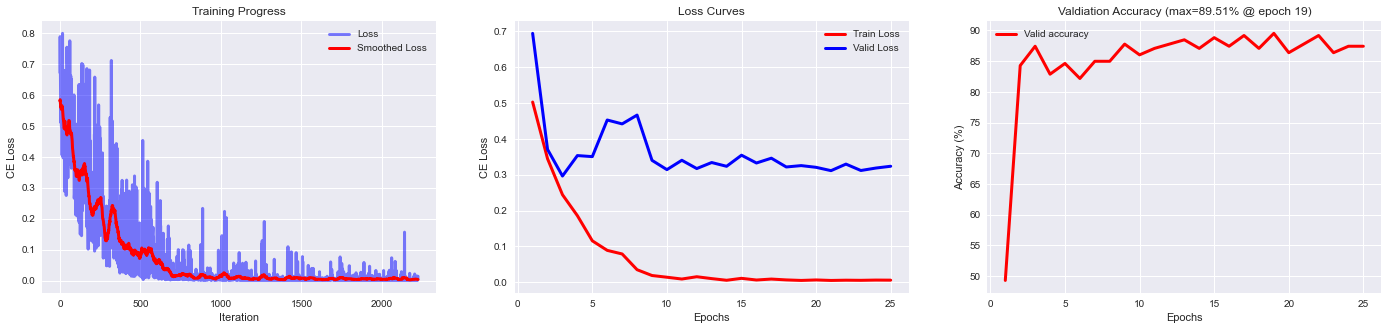

In [17]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()


In [18]:
num = list(range(0,10))
df = pd.DataFrame(num, columns = ['Epochs'])
df['Train Loss'] = pd.DataFrame(train_loss)
df['Validation Loss'] = pd.DataFrame(val_loss)
df['Validation Acc'] = pd.DataFrame(valid_acc)
df.to_csv('finetune_resnet.csv', sep=',',index = False)
df1 = pd.read_csv('finetune_resnet.csv')
df1.head(10)

,Epochs,Train Loss,Validation Loss,Validation Acc
0,0,0.502954,0.694808,49.300699
1,1,0.344556,0.370633,84.265734
2,2,0.244154,0.296292,87.412587
3,3,0.185536,0.353450,82.867133
4,4,0.115355,0.350500,84.615385
5,5,0.088660,0.452765,82.167832
6,6,0.078612,0.441905,84.965035
7,7,0.034669,0.466520,84.965035
8,8,0.018450,0.340166,87.762238
9,9,0.013666,0.314184,86.013986


In [19]:
test_dataset = datasets.ImageFolder('data/test', data_transforms["val"])

N_test = len(test_dataset)
print(f"Testing set size: {N_test} images")


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=True, num_workers=4)


Testing set size: 656 images


In [20]:
class_names = test_dataset.classes
print(class_names)

['bad', 'good']


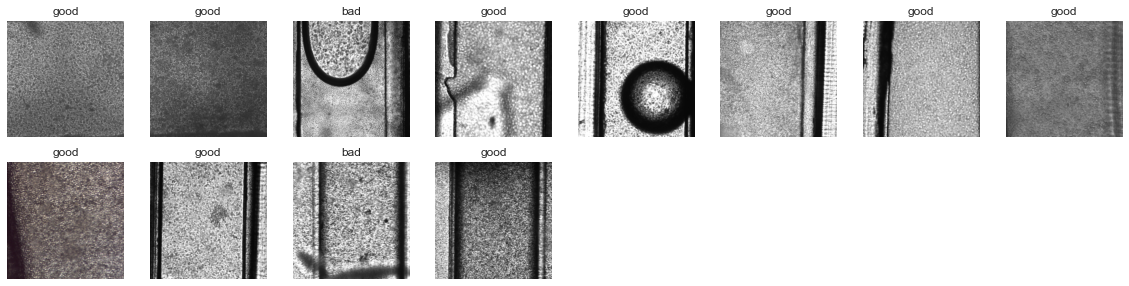

In [21]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)

    plt.figure(figsize=(8*2, 4*2))
    for i in range(12):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

# Get a batch of training data and displaying it
inputs, classes = next(iter(test_loader))
titles = [class_names[x] for x in classes]

show_grid(inputs, titles=titles)

In [22]:
device

device(type='cuda')

In [ ]:

# validation epoch
model.eval()  # important for dropout and batch norms
Taccuracy, Tloss = eval_model(
            model=model, eval_loader=test_loader,
            criterion=criterion, device=device
    )

In [7]:
Taccuracy

NameError: name 'Taccuracy' is not defined

In [ ]:
Test Accuracy = 88.41463414634147%

### VGG

In [ ]:
# downloading pretrained model
model = models.vgg16(pretrained=True)

#https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch

num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2)]) # Add our layer with 2 outputs namely person and robot
model.classifier = nn.Sequential(*features) # Replace the model classifier
print(model)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 69.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
start = time.time()
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=10
    )
end = time.time()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/10
    Train loss: 0.69891
    Valid loss: 0.68464
    Accuracy: 59.09090909090909%


Epoch 6/10
    Train loss: 0.62083
    Valid loss: 0.56225
    Accuracy: 70.27972027972028%


Epoch 10/10
    Train loss: 0.45958
    Valid loss: 0.51311
    Accuracy: 74.82517482517483%


Training completed


In [ ]:
print("Time Elapsed = ",end-start," seconds")

Time Elapsed =  1967.798145532608  seconds


In [ ]:
print(count_model_params(model))

134268738


<ipython-input-23-e0510c29302a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


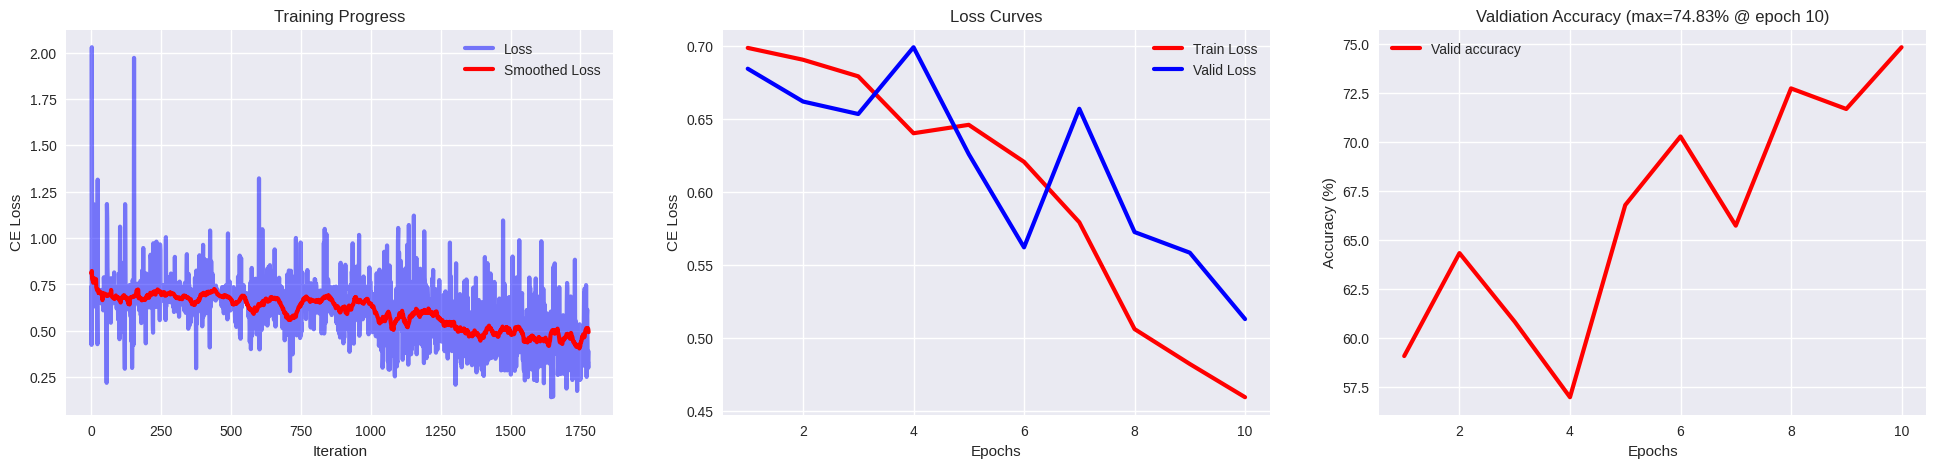

In [ ]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()
